In [69]:
import json

with open('bundesliga.json', 'r', encoding='utf-8') as f:
    bl_shots = json.load(f)

In [70]:
shot_index = 10
shot_event = bl_shots[shot_index]

print('shot_event')
print()
print(shot_event.keys())

shot_event

dict_keys(['id', 'index', 'period', 'timestamp', 'minute', 'second', 'type', 'possession', 'possession_team', 'play_pattern', 'team', 'player', 'position', 'location', 'duration', 'under_pressure', 'related_events', 'shot'])


In [71]:
shot_data = shot_event['shot']

print('shot_data')
print()
print(shot_data.keys())

shot_data

dict_keys(['statsbomb_xg', 'end_location', 'key_pass_id', 'type', 'outcome', 'technique', 'aerial_won', 'body_part', 'freeze_frame'])


In [72]:
freeze_frame = shot_data['freeze_frame']

print('freeze_frame')
print()
print('Array of these...')
print(freeze_frame[0].keys())

freeze_frame

Array of these...
dict_keys(['location', 'player', 'position', 'teammate'])


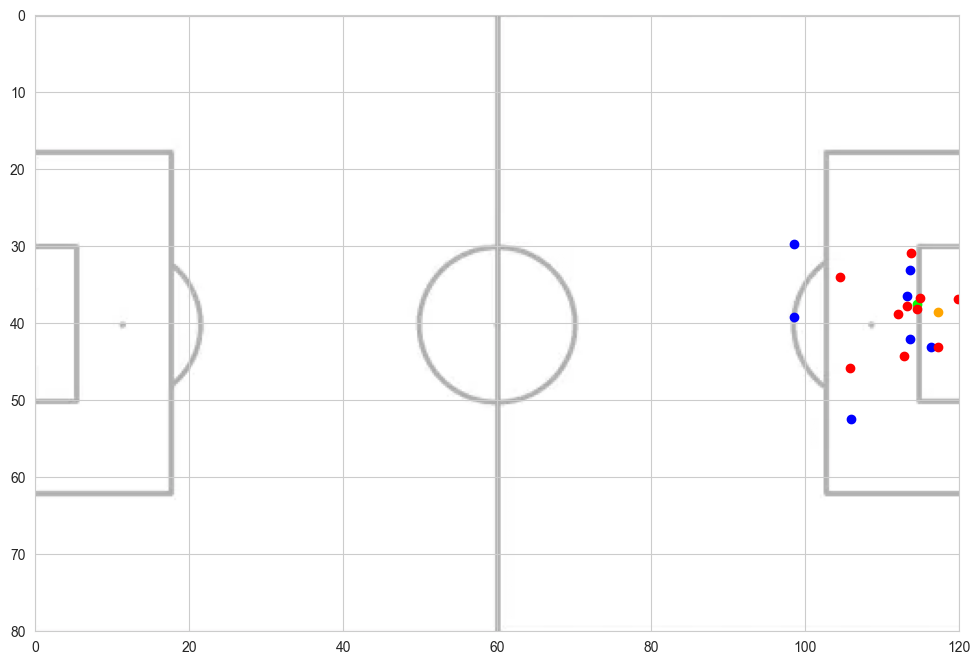

In [75]:
# print out a graph of all of the positions the players are in, colour coded by team (special colours for kicker and keeper)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def print_shot(shot_event, freeze_frame):

    shot_location = shot_event['location']
    team_locations = []
    op_locations = []
    keeper_location = []

    for player in freeze_frame:
        if player['teammate']:
            team_locations.append(player['location'])
        else:
            if player['position']['id'] == 1:
                keeper_location = player['location']
            else:
                op_locations.append(player['location'])

    pitch_image = mpimg.imread('pitch.png')

    # Extracting x and y coordinates for each team
    shot_x, shot_y = [shot_location[0]], [shot_location[1]]
    keeper_x, keeper_y = [keeper_location[0]], [keeper_location[1]]
    team_x, team_y = zip(*team_locations)
    op_x, op_y = zip(*op_locations)

    # Creating the plot
    plt.figure(figsize=(12, 8))
    plt.imshow(pitch_image, extent=(0., 120., 0., 80.))

    # Plotting shot location
    plt.scatter(shot_x, shot_y, color='lime', label='Shot')
    # Plotting keeper location
    plt.scatter(keeper_x, keeper_y, color='orange', label='GK')
    # Plotting team locations
    plt.scatter(team_x, team_y, color='blue', label='Team')
    # Plotting opponent locations
    plt.scatter(op_x, op_y, color='red', label='Opponents')

    # Setting the x and y limits
    plt.xlim(0, 120)
    plt.ylim(0, 80)

    plt.gca().invert_yaxis()

    # Display the plot
    plt.show()

print_shot(shot_event, freeze_frame)


In [66]:
# How many opposing players are nearby
# GK position (in position... if they're in the angle)

import numpy as np

final_shots = []

left_goalpost = np.array([120,36])
right_goalpost = np.array([120,44])
goal_center = np.array([120,40])

def points_in_triangle(op_locations, a, b, c):
    area_abc = 0.5 * np.abs(
        a[0] * (b[1] - c[1]) +
        b[0] * (c[1] - a[1]) +
        c[0] * (a[1] - b[1])
    )

    area_abd = 0.5 * np.abs(
        a[0] * (b[1] - op_locations[:, 1]) +
        b[0] * (op_locations[:, 1] - a[1]) +
        op_locations[:, 0] * (a[1] - b[1])
    )

    area_bcd = 0.5 * np.abs(
        b[0] * (c[1] - op_locations[:, 1]) +
        c[0] * (op_locations[:, 1] - b[1]) +
        op_locations[:, 0] * (b[1] - c[1])
    )

    area_cad = 0.5 * np.abs(
        c[0] * (a[1] - op_locations[:, 1]) +
        a[0] * (op_locations[:, 1] - c[1]) +
        op_locations[:, 0] * (c[1] - a[1])
    )

    in_triangle = np.isclose(area_abc, area_abd + area_bcd + area_cad)
    return np.sum(in_triangle)


non_attacking_positions = ['Goalkeeper', 'Right Back', 'Right Center Back', 'Center Back', 'Left Center Back', 'Left Back', 'Right Wing Back', 'Left Wing Back', 'Right Defensive Midfield', 'Center Defensive Midfield', 'Left Defensive Midfield', 'Right Midfield', 'Right Center Midfield', 'Center Midfield', 'Left Center Midfield', 'Left Midfield']
attacking_positions = ['Right Wing', 'Right Attacking Midfield', 'Center Attacking Midfield', 'Left Attacking Midfield', 'Left Wing', 'Right Center Forward', 'Striker', 'Left Center Forward', 'Secondary Striker']


for index, shot_event in enumerate(bl_shots):

    if index > 10:
        break

    final_shot = {}

    shot_data = shot_event['shot']
    freeze_frame = shot_data['freeze_frame']

    shot_location = np.array(shot_event['location'])

    team_locations = np.empty((0, 2))
    op_locations = np.empty((0, 2))
    # will be a np array with 1 value ...
    keeper_location = np.empty((0, 2))

    for player in freeze_frame:

        player_location = np.array(player['location'])

        if player['teammate']:
            team_locations = np.vstack([team_locations,player_location])
        else:
            # Different to the plot above, keeper is included in ops
            if player['position']['id'] == 1:
                keeper_location = np.vstack([keeper_location, player_location])

            op_locations = np.vstack([op_locations,player_location])

    # Distance
    final_shot['distance'] = np.linalg.norm(shot_location - goal_center)

    # Angle to goal
    a = left_goalpost
    b = shot_location
    c = right_goalpost

    # Cosine rule to find angle
    BA = a - b
    BC = c - b
    dot_product = np.dot(BA, BC)
    magnitude_BA = np.linalg.norm(BA)
    magnitude_BC = np.linalg.norm(BC)
    cos_theta = dot_product / (magnitude_BA * magnitude_BC)
    final_shot['angle'] = np.arccos(cos_theta)

    # Is the keeper in the angle?
    final_shot['keeper_in_position'] = points_in_triangle(keeper_location,left_goalpost,shot_location,right_goalpost)

    # how many bodies in the way?
    final_shot['blocking_bodies'] = points_in_triangle(op_locations,left_goalpost,shot_location,right_goalpost)

    # Number of surrounding players (2 yards)
    op_distances = np.linalg.norm(op_locations - shot_location, axis=1)
    final_shot['pressuring_players'] = np.sum(op_distances <= 2)

    # Important shot_event data
    final_shot['id'] = shot_event['id']
    final_shot['team'] = shot_event['team']['name']
    final_shot['player'] = shot_event['player']['name']

    # One hot encode
    final_shot['attacking_position'] = 1 if shot_event['position']['name'] in attacking_positions else 0

    # These only appear in the data if they're true
    # final_shot['first_time'] = 1 if 'first_time' in shot_data else 0
    # final_shot['under_pressure'] = 1 if 'under_pressure' in shot_data else 0

    # corner, kickoff, openplay fall into both off to avoid dvt
    final_shot['penalty'] = 1 if shot_data['type']['name'] == 'Penalty' else 0
    final_shot['freekick'] = 1 if shot_data['type']['name'] == 'Free Kick' else 0

    #  Normal', 'Lob' fall into all off to avoid dvt
    final_shot['technique_weird'] = 1 if shot_data['technique']['name'] in ['Overhead Kick', 'Backheel', 'Diving Header'] else 0
    final_shot['technique_halfvolley'] = 1 if shot_data['technique']['name'] == 'Half Volley' else 0
    final_shot['technique_volley'] = 1 if shot_data['technique']['name'] == 'Volley' else 0

    # Right foot is all off to avoid dvt
    final_shot['bodypart_head'] = 1 if shot_data['body_part']['name'] == 'Head' else 0
    final_shot['bodypart_leftfoot'] = 1 if shot_data['body_part']['name'] == 'Left Foot' else 0
    final_shot['bodypart_other'] = 1 if shot_data['body_part']['name'] == 'Other' else 0

    # OUTCOME
    final_shot['goal'] = 1 if shot_data['outcome']['name'] == 'Goal' else 0

    print(index)
    for key,value in final_shot.items():
        print(key, value)
    print()


0
distance 14.800337833982038
angle 0.4384185725760543
keeper_in_position 1
blocking_bodies 3
pressuring_players 0
id ba46e9d6-e828-4599-952c-39c1f7d22659
team Hoffenheim
player Tarik Elyounoussi
attacking_position 0
penalty 0
freekick 0
technique_weird 0
technique_halfvolley 1
technique_volley 0
bodypart_head 0
bodypart_leftfoot 1
bodypart_other 0
goal 0

1
distance 9.464142856064669
angle 0.7801375710831983
keeper_in_position 1
blocking_bodies 1
pressuring_players 1
id 85d67225-30fb-47c8-b478-cf568941a164
team Schalke 04
player Klaas-Jan Huntelaar
attacking_position 0
penalty 0
freekick 0
technique_weird 0
technique_halfvolley 0
technique_volley 1
bodypart_head 0
bodypart_leftfoot 0
bodypart_other 0
goal 1

2
distance 11.100450441310928
angle 0.1554234795738524
keeper_in_position 0
blocking_bodies 1
pressuring_players 1
id adac17d3-5e67-4e8c-b482-4bae2f36e06e
team Hoffenheim
player Kevin Volland
attacking_position 1
penalty 0
freekick 0
technique_weird 0
technique_halfvolley 1
techni